In [28]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

def get_dose_values(fp):
    with open(fp, 'rb') as f:
        data = pickle.load(f)
    return pd.DataFrame.from_records(data)

## Load the Data

In [29]:
fol = r'\\ad\dfs\Shared Data\MCI Proton\Mauricio\Computational physicist\dose_let_stats'
df = pd.DataFrame()
for file in os.listdir(fol):
    if file.endswith('.csv'):
        dfi = pd.read_csv(os.path.join(fol, file))
        df = pd.concat([df, dfi],ignore_index=True)
        

In [120]:
def get_ldvh(df,patient,roi,dose_variable, y_variable = 'LETd [keV/um]', num_bins = 20, bin_spacing = None, Bins=None):
    dfp = df[(df['Patient']==patient) & (df['ROI']==roi)].copy()
    if patient == 'NasoLET_Project_9':
        # Change Beams1_Clinical_norm to Beam1_Clinical_norm
        dfp.loc[:,'Plan'] = dfp['Plan'].str.replace('Beams1_Clinical_norm','Beam1_Clinical_norm').replace('Beams2_Test_norm','Beam2_Test_norm')
    # Now let's focus only on Beam1_Clinical_norm
    df1 = dfp[dfp['Plan'].str.lower() == 'Beam1_Clinical_norm'.lower()].copy()
    df2 = dfp[dfp['Plan'].str.lower() == 'Beam2_Test_norm'.lower()].copy()
    # Let's get the dose values for RBE_1.1 and LETd
    dose_values1= get_dose_values(df1.loc[(df1['Model'] == dose_variable)]['Values'].iloc[0])
    letd_values1= get_dose_values(df1.loc[(df1['Model'] == 'LETd [keV/um]')]['Values'].iloc[0])
    dose_values2= get_dose_values(df2.loc[(df2['Model'] == dose_variable)]['Values'].iloc[0])
    letd_values2= get_dose_values(df2.loc[(df2['Model'] == 'LETd [keV/um]')]['Values'].iloc[0])

    if y_variable == 'LETd [keV/um]':
        if not bin_spacing:  
            bins = np.linspace(0,np.ceil(np.max([dose_values1['dose'].max(),dose_values2['dose'].max()])),num_bins)
        else:
            bins = np.arange(0,np.ceil(np.max([dose_values1['dose'].max(),dose_values2['dose'].max()]))+bin_spacing,bin_spacing)
        
        if np.any(Bins):
            bins = Bins

        dose_values1['Bin'] = pd.cut(dose_values1['dose'], bins)
        dose_values2['Bin'] = pd.cut(dose_values2['dose'], bins)

        # Merge dose and letd values on index and weights
        df_1 = pd.merge(dose_values1, letd_values1, on=['index','weights'], suffixes=('_dose', '_letd'))
        df_2 = pd.merge(dose_values2, letd_values2, on=['index','weights'], suffixes=('_dose', '_letd'))

        df_1['LETd*Weight'] = df_1['letd']*df_1['weights']
        df_2['LETd*Weight'] = df_2['letd']*df_2['weights']

        df_ldvh_1 = df_1.groupby('Bin').sum()
        df_ldvh_1.reset_index(inplace=True)
        df_ldvh_1['Average LETd [by volume]'] = df_ldvh_1['LETd*Weight']/df_ldvh_1['weights']

        df_ldvh_2 = df_2.groupby('Bin').sum()
        df_ldvh_2.reset_index(inplace=True)
        df_ldvh_2['Average LETd [by volume]'] = df_ldvh_2['LETd*Weight']/df_ldvh_2['weights']

        # merge df_ldvh
        df_ldvh = pd.merge(df_ldvh_1, df_ldvh_2, on='Bin', suffixes=('_Beam1', '_Beam2'))

        # Only keep Bin, and letd averages
        df_ldvh = df_ldvh[['Bin','Average LETd [by volume]_Beam1','Average LETd [by volume]_Beam2']]
        # Melt the data
        df_ldvh_melt = pd.melt(df_ldvh, id_vars=['Bin'], value_vars=['Average LETd [by volume]_Beam1','Average LETd [by volume]_Beam2'])
    else:
        if not bin_spacing:
            bins = np.linspace(0,np.ceil(np.max([letd_values1['letd'].max(),letd_values2['letd'].max()])),num_bins)
        else:
            bins = np.arange(0,np.ceil(np.max([letd_values1['letd'].max(),letd_values2['letd'].max()]))+bin_spacing,bin_spacing)
        if np.any(Bins):
            bins = Bins
            
        letd_values1['Bin'] = pd.cut(letd_values1['letd'], bins)
        letd_values2['Bin'] = pd.cut(letd_values2['letd'], bins)

        # Merge dose and letd values on index and weights
        df_1 = pd.merge(dose_values1, letd_values1, on=['index','weights'], suffixes=('_dose', '_letd'))
        df_2 = pd.merge(dose_values2, letd_values2, on=['index','weights'], suffixes=('_dose', '_letd'))

        df_1['Dose*Weight'] = df_1['dose']*df_1['weights']
        df_2['Dose*Weight'] = df_2['dose']*df_2['weights']

        df_ldvh_1 = df_1.groupby('Bin').sum()
        df_ldvh_1.reset_index(inplace=True)
        df_ldvh_1['Average Dose [by volume]'] = df_ldvh_1['Dose*Weight']/df_ldvh_1['weights']

        df_ldvh_2 = df_2.groupby('Bin').sum()
        df_ldvh_2.reset_index(inplace=True)
        df_ldvh_2['Average Dose [by volume]'] = df_ldvh_2['Dose*Weight']/df_ldvh_2['weights']

        # merge df_ldvh
        df_ldvh = pd.merge(df_ldvh_1, df_ldvh_2, on='Bin', suffixes=('_Beam1', '_Beam2'))
        
        # Only keep Bin, and dose averages
        df_ldvh = df_ldvh[['Bin','Average Dose [by volume]_Beam1','Average Dose [by volume]_Beam2']]
        # Melt the data
        df_ldvh_melt = pd.melt(df_ldvh, id_vars=['Bin'], value_vars=['Average Dose [by volume]_Beam1','Average Dose [by volume]_Beam2'])
    
    return df_ldvh_melt


    
    

In [75]:
from tqdm import tqdm

In [131]:
df.loc[:,'ROI'] = df['ROI'].str.replace('OpticChiasm','Chiasm')
df['ROI'].value_counts()

Brain           50
BrainStem       50
Chiasm          50
Cochlea_L       50
Cochlea_R       50
Eye_L           50
Eye_R           50
Lens_L          50
Lens_R          50
OpticNerve_L    50
OpticNerve_R    50
PharynxConst    50
SpinalCord      50
Retina_L        40
Retina_R        40
Name: ROI, dtype: int64

Processing patients: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
C:\Users\mau22560.AD\AppData\Local\Temp/ipykernel_26540/3199455344.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(2,3,figsize=(12,7), sharey=True)
Processing patients: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


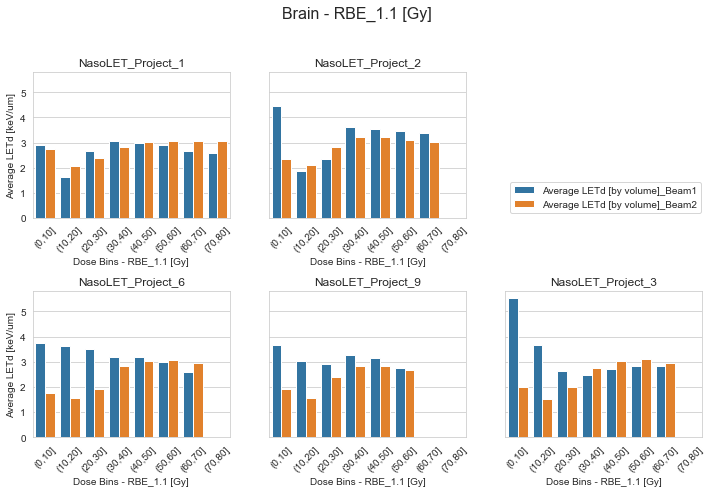

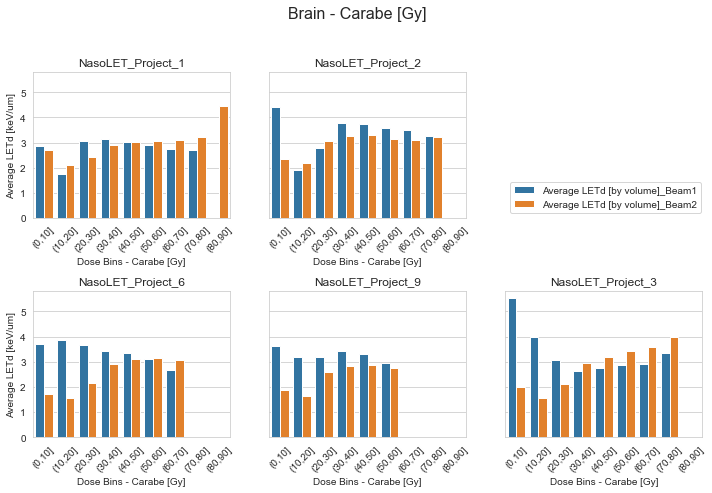

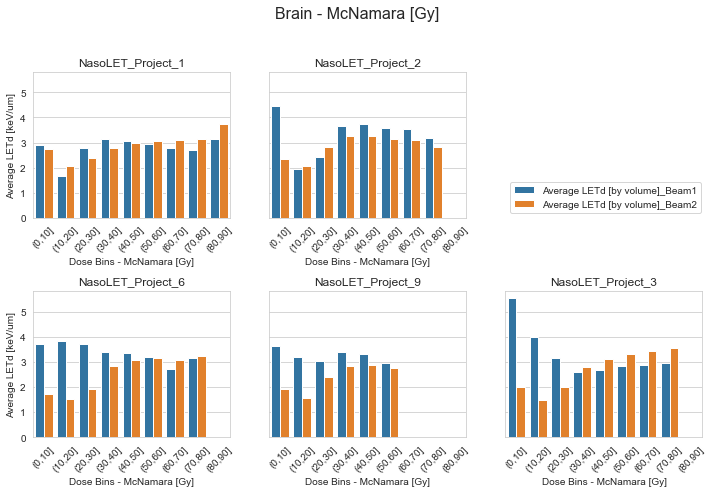

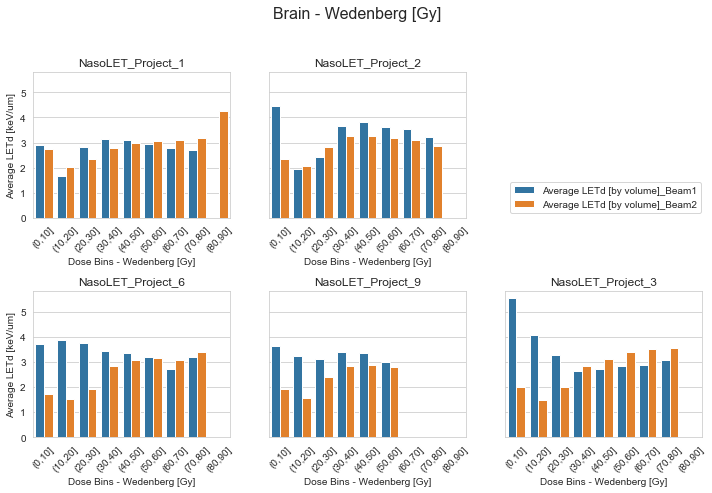

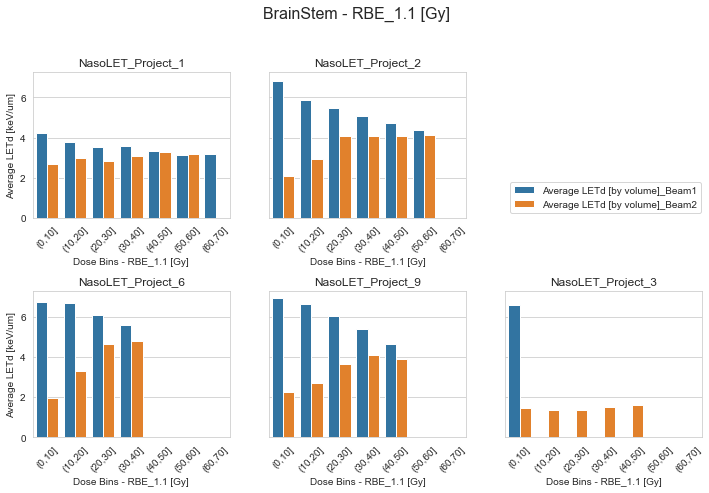

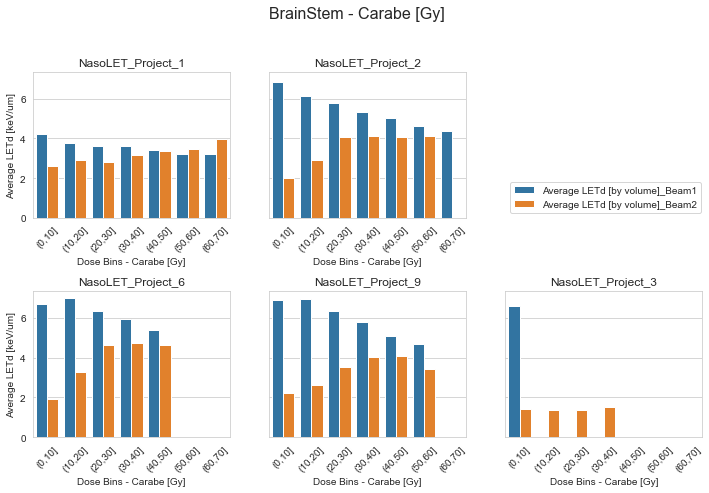

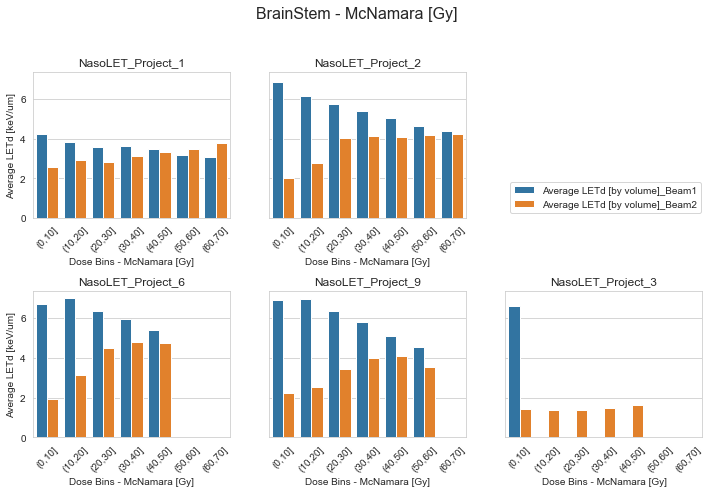

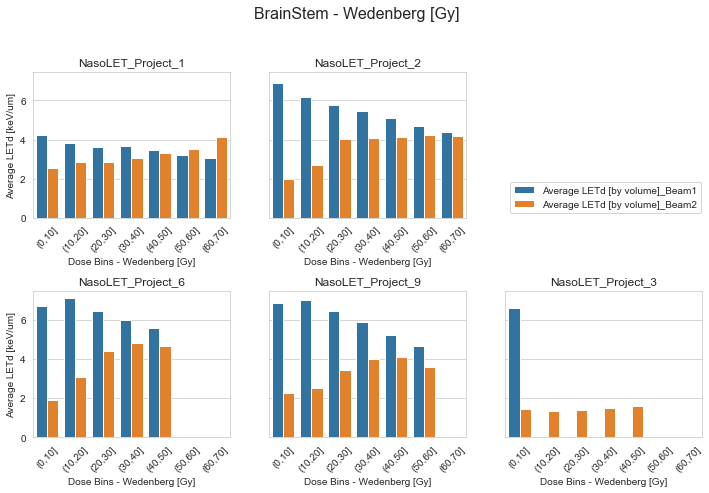

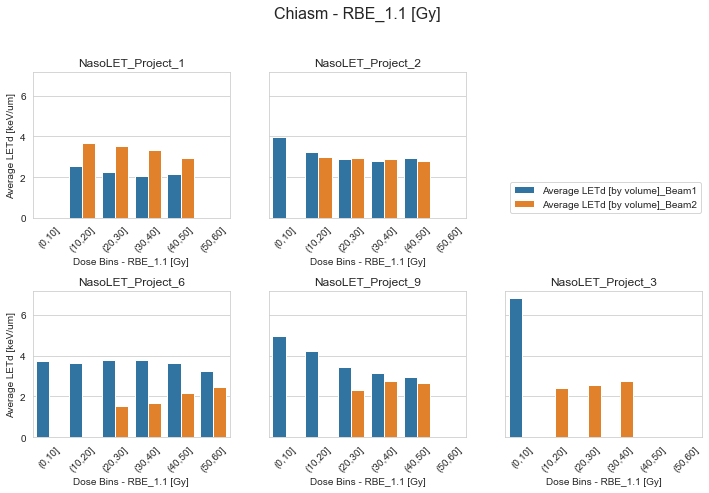

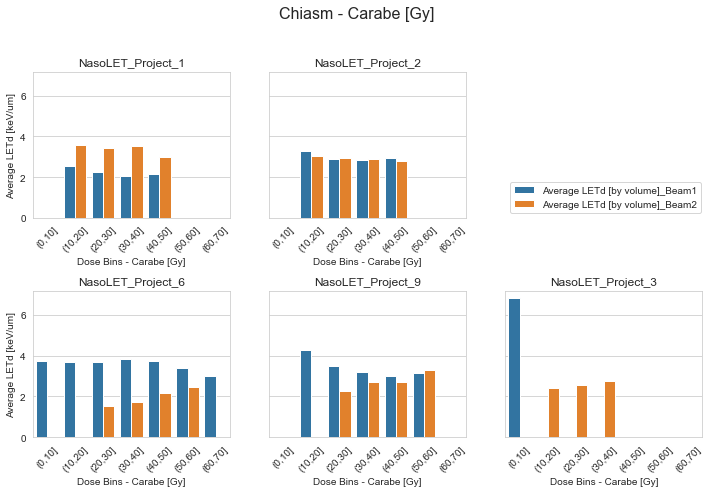

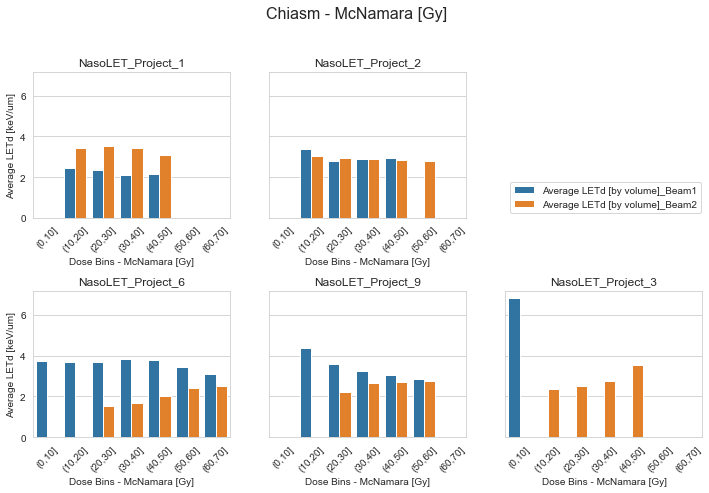

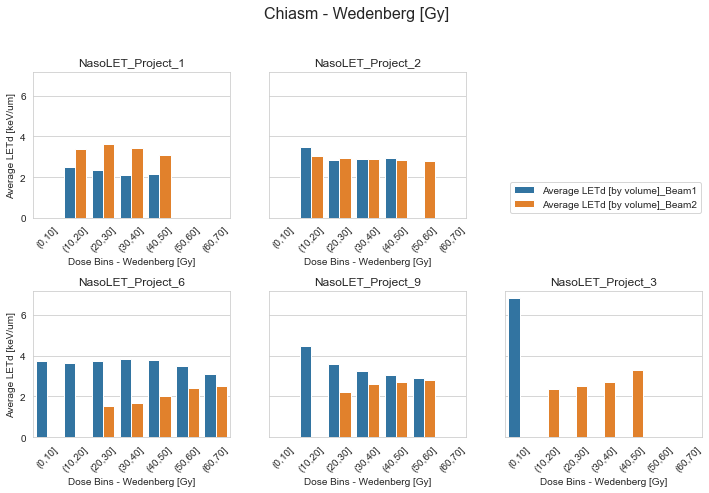

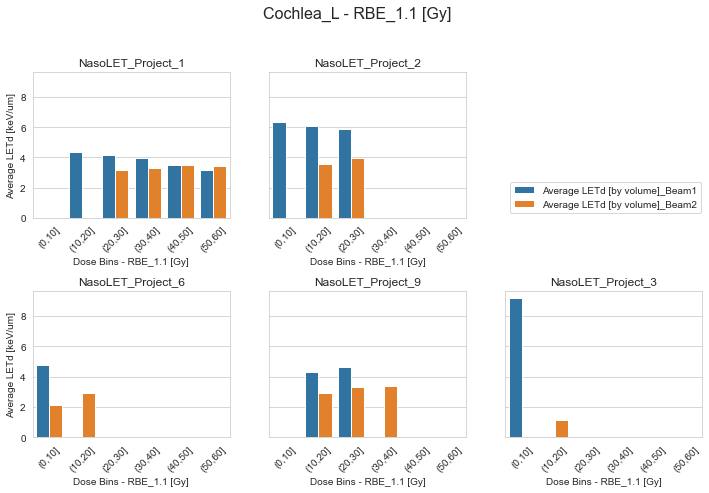

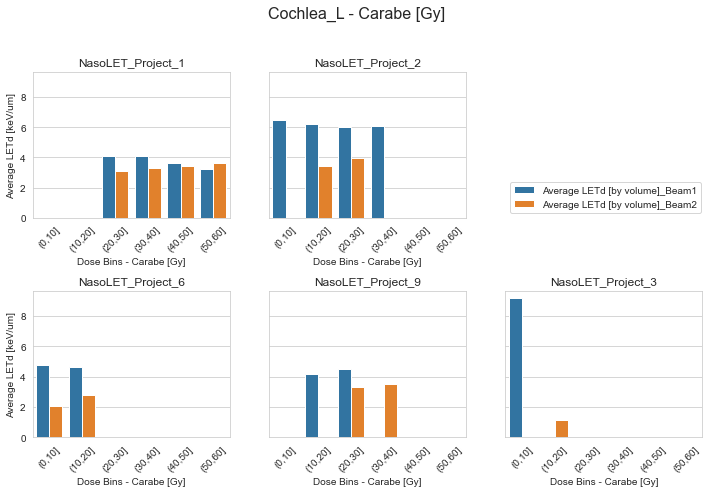

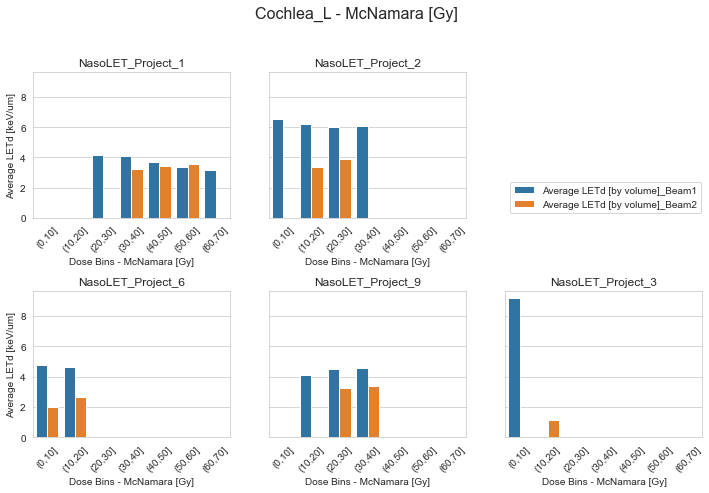

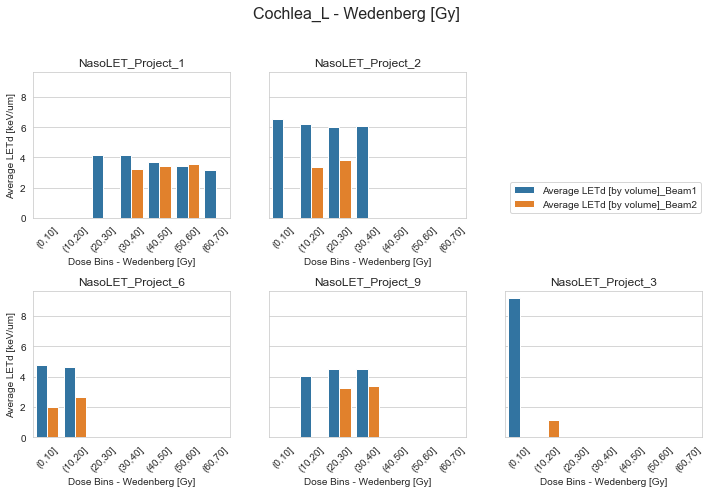

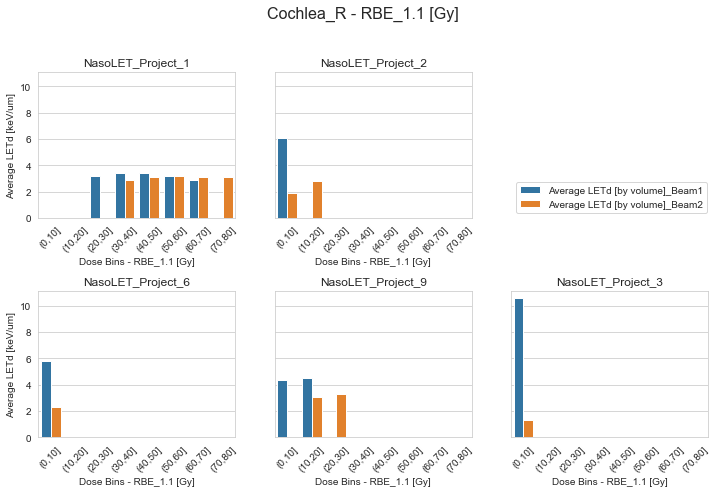

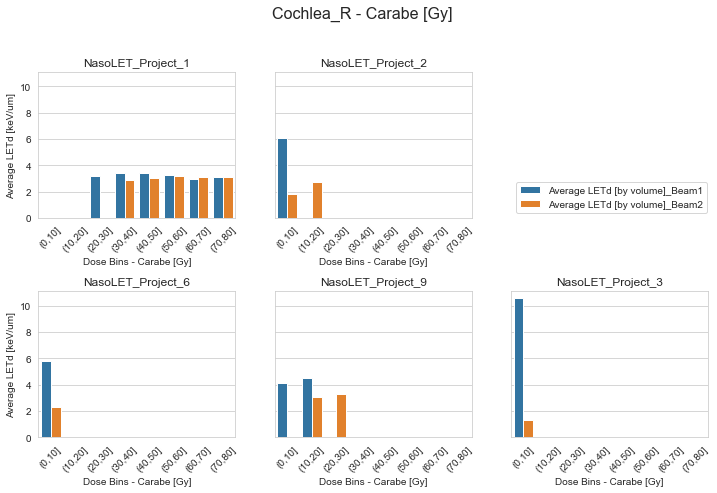

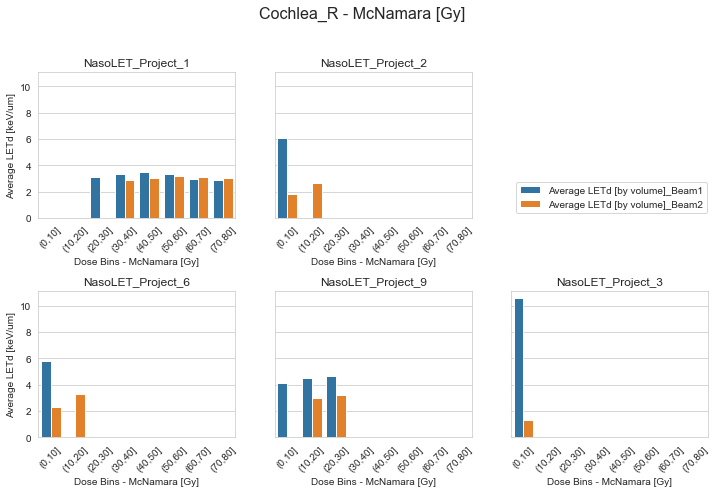

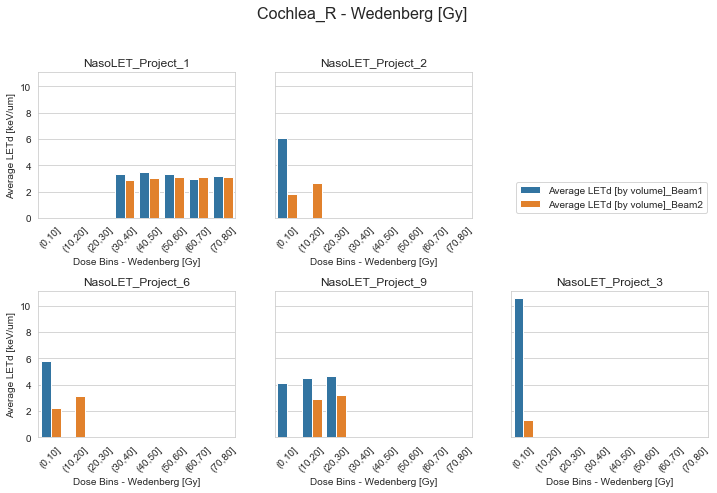

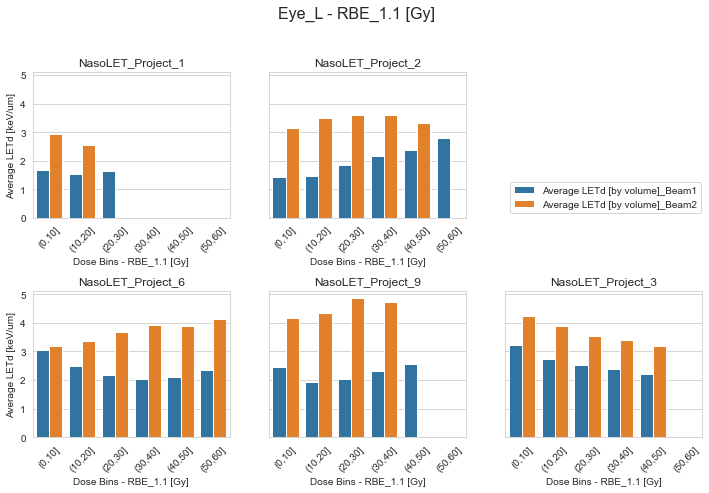

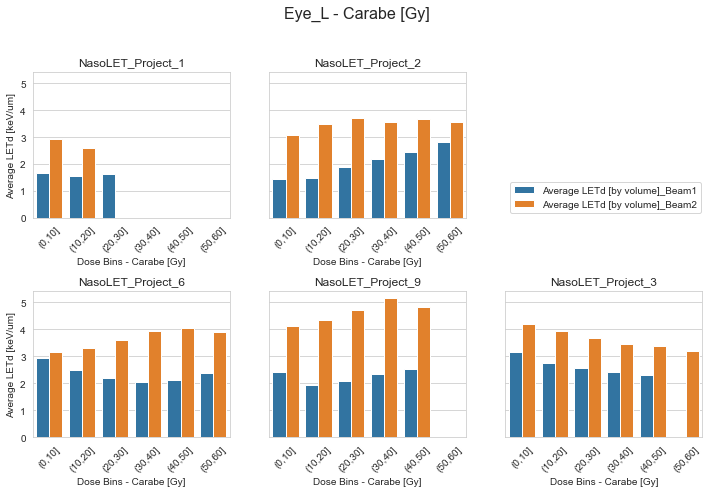

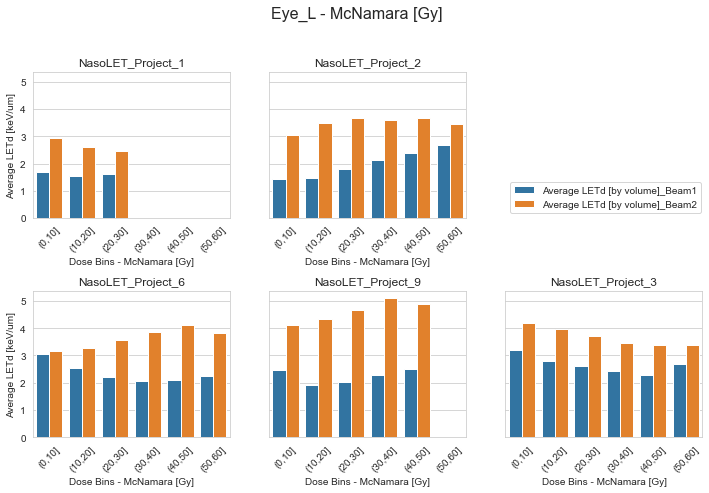

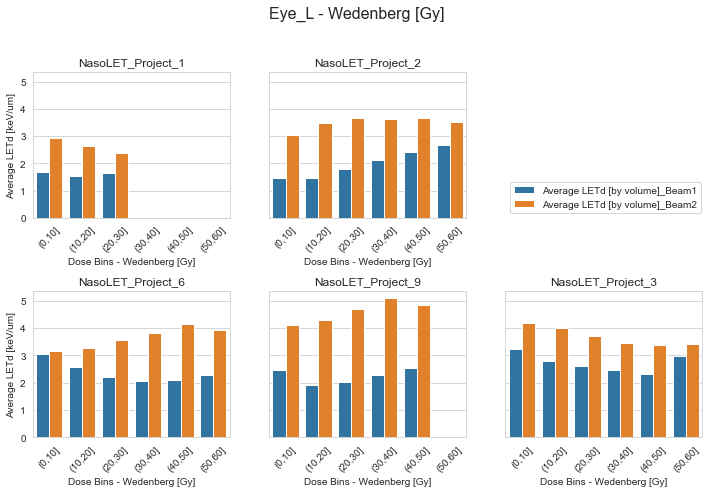

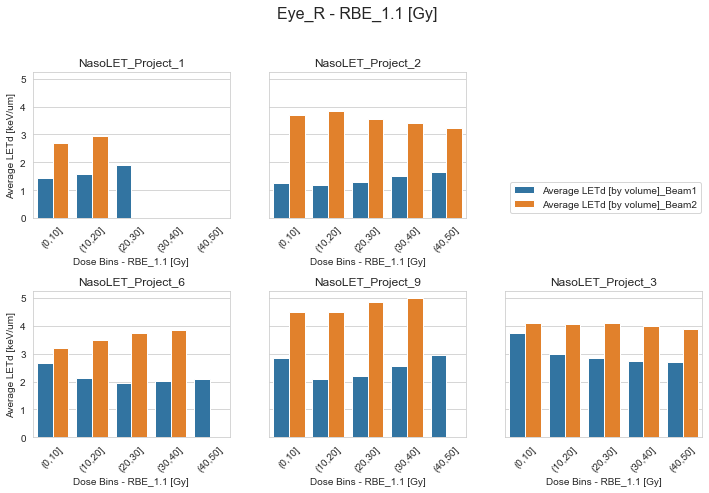

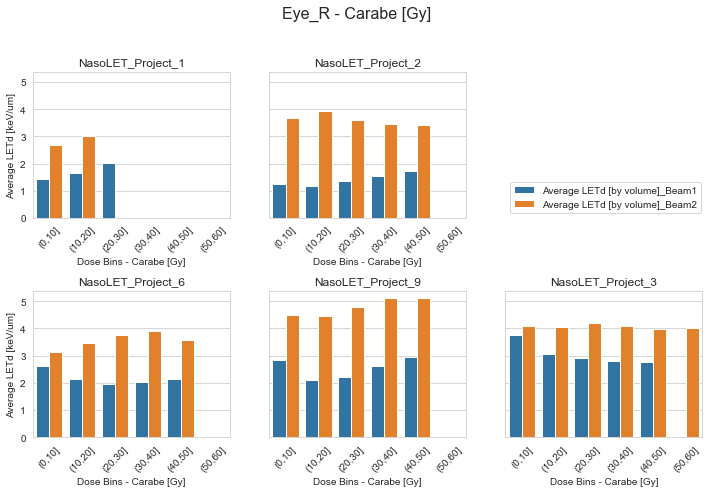

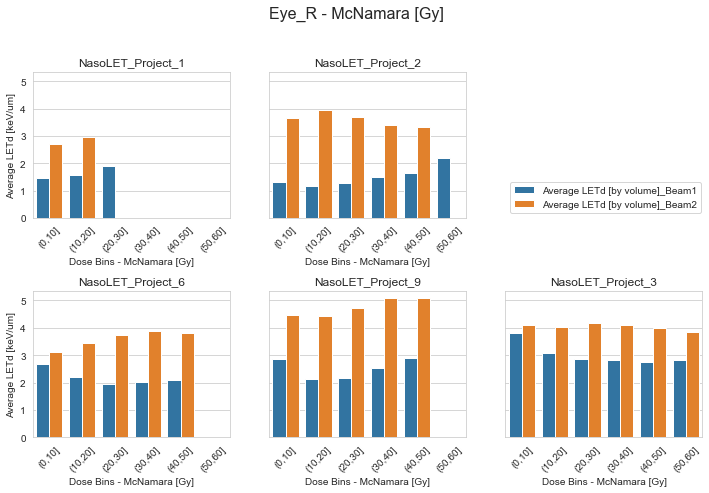

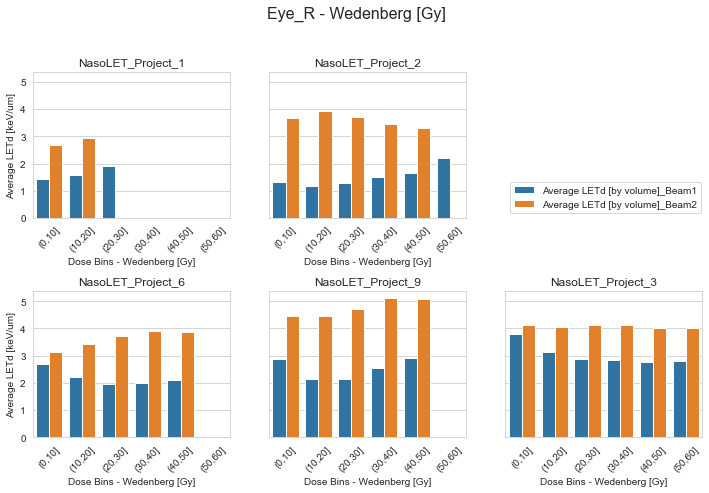

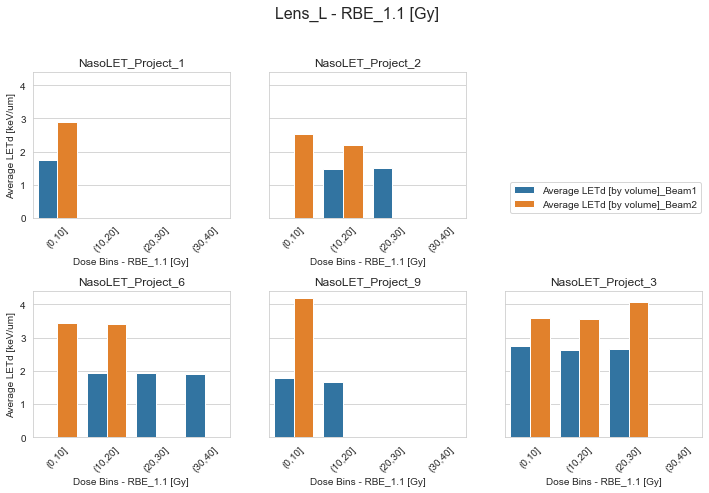

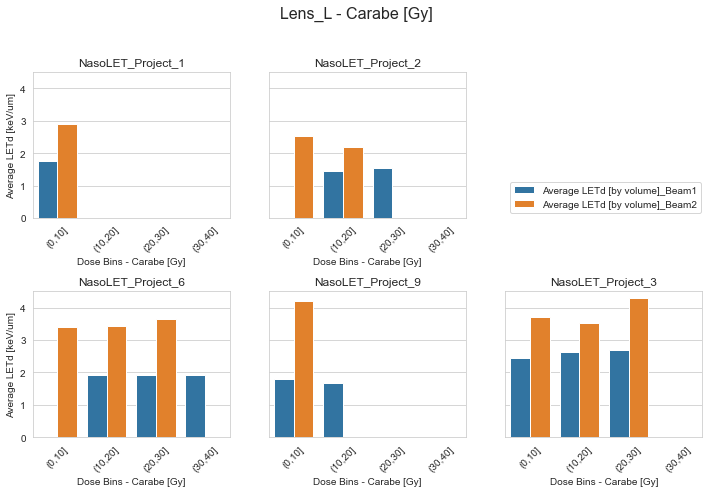

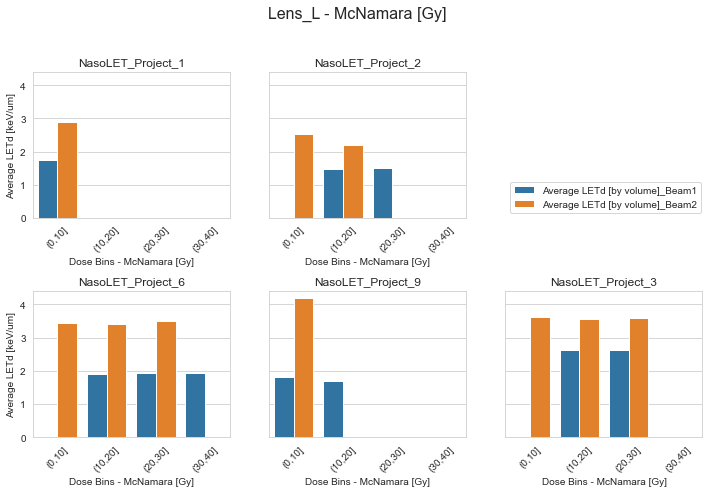

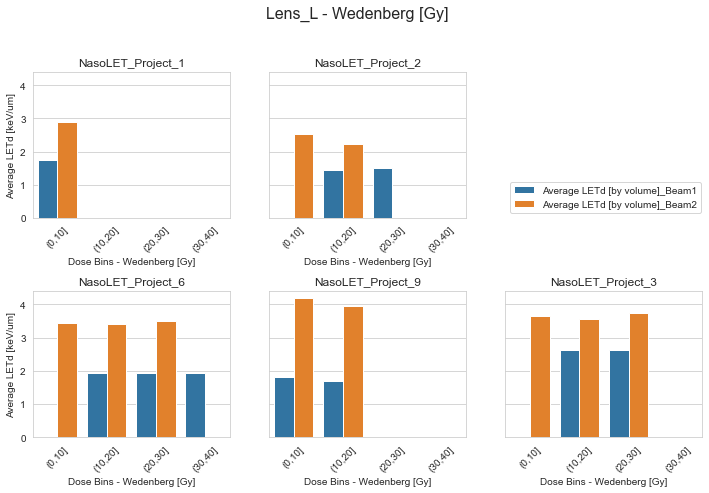

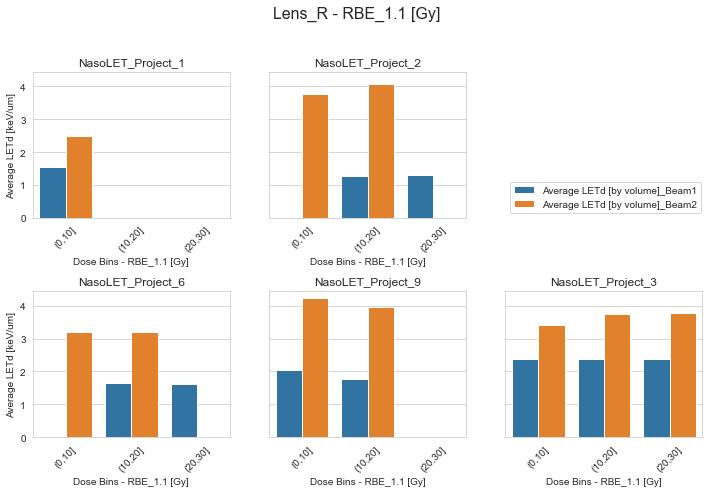

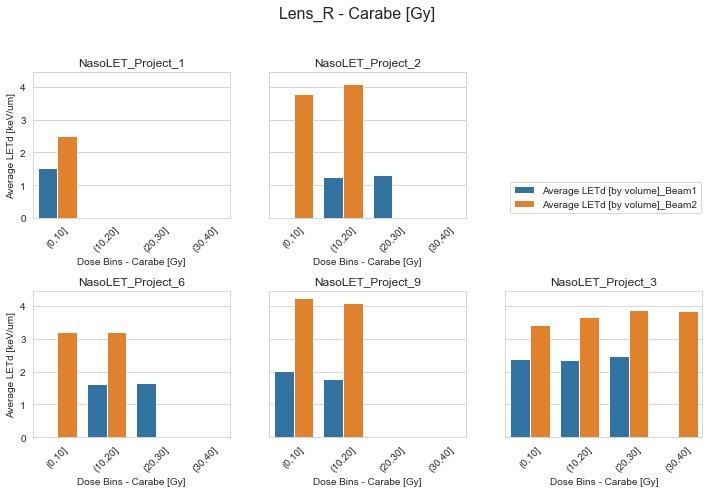

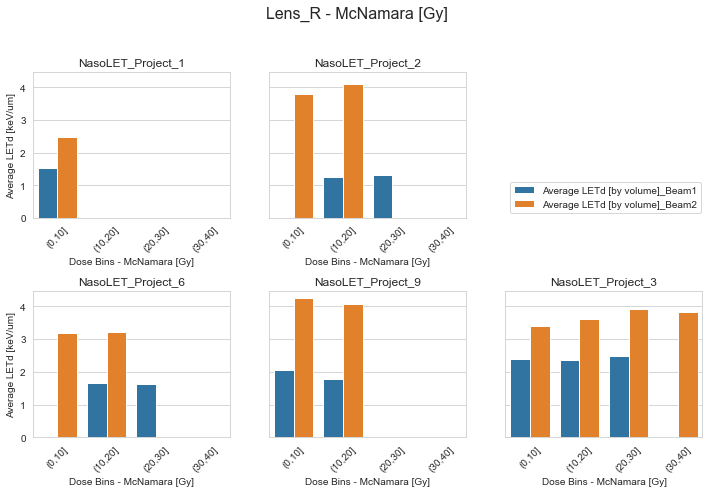

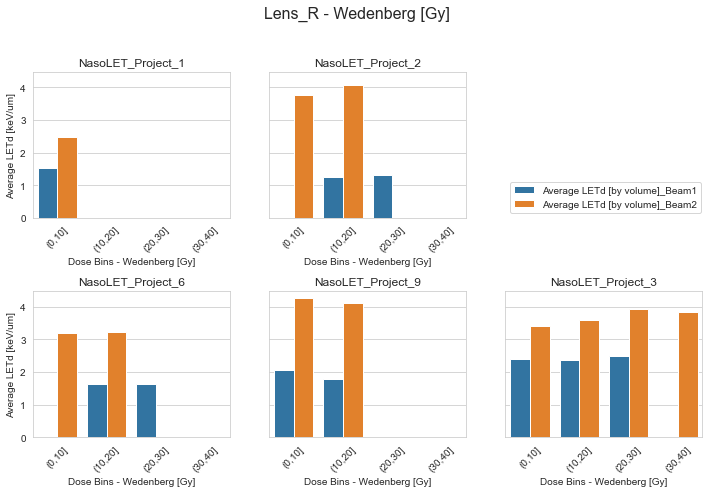

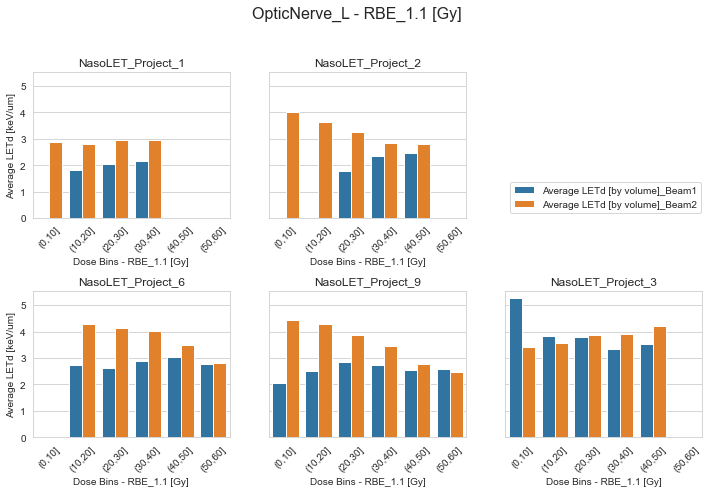

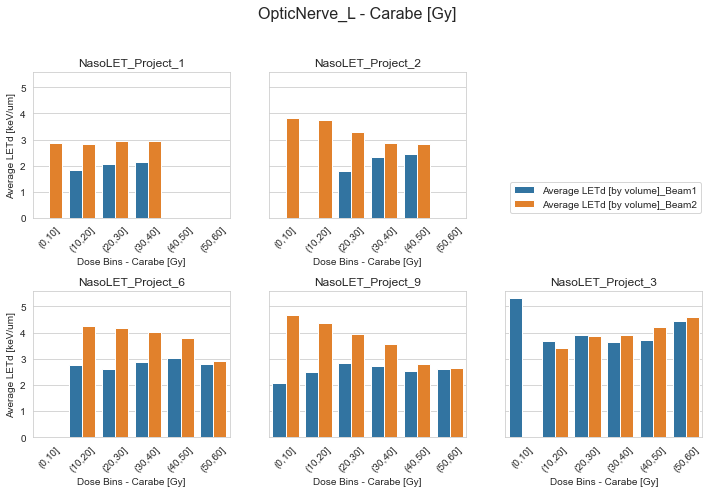

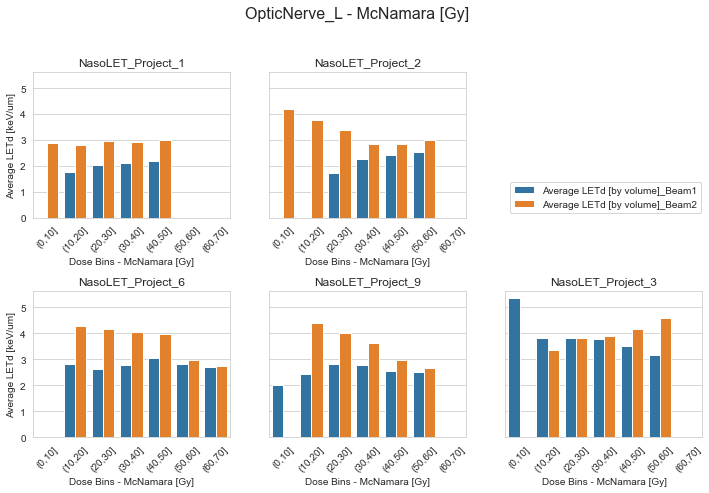

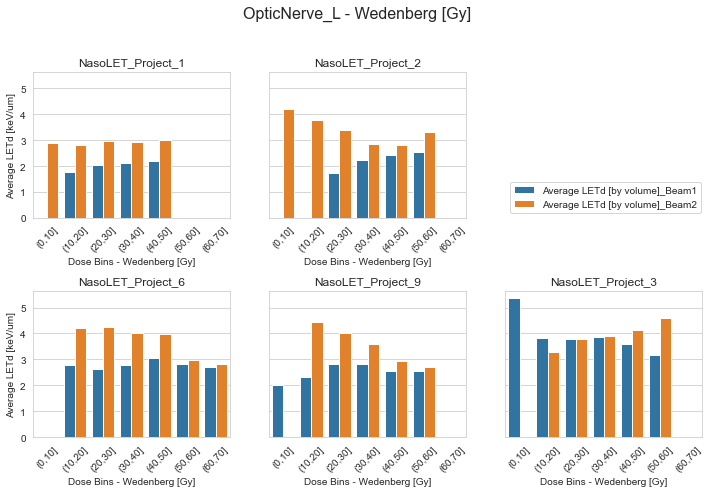

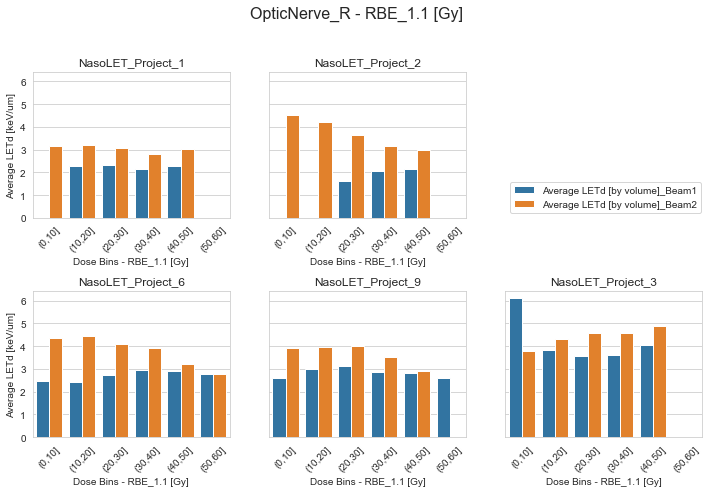

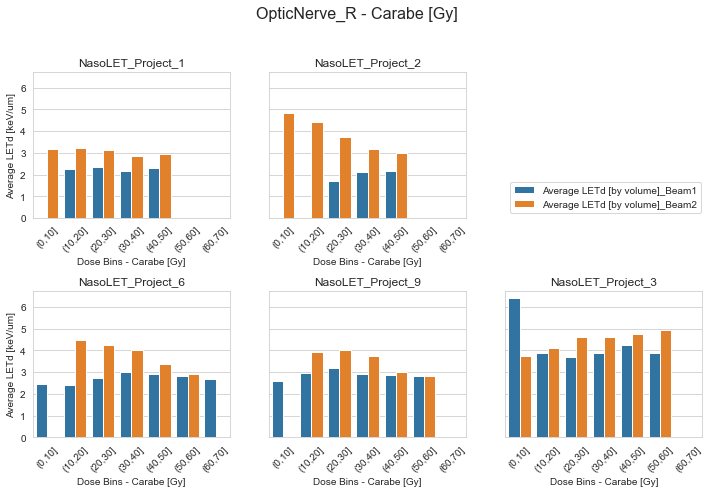

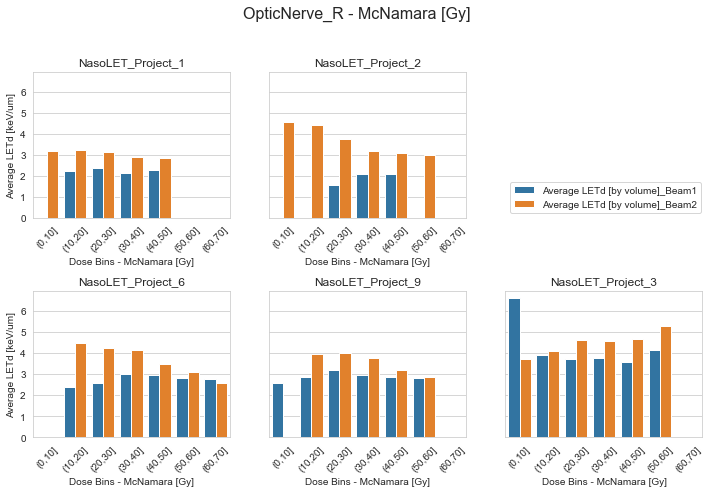

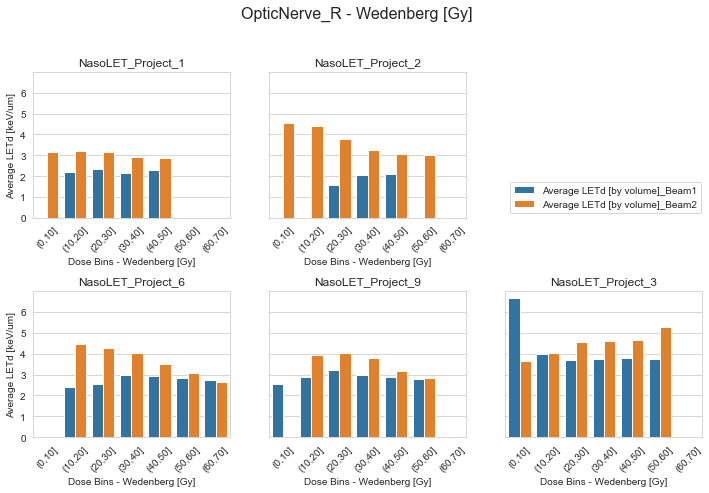

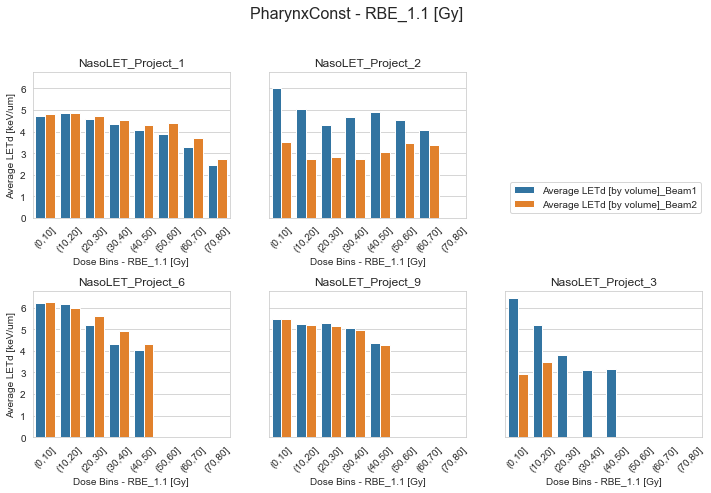

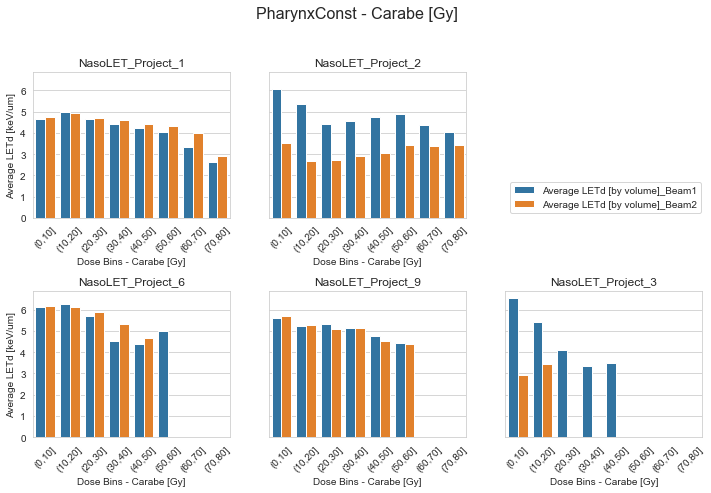

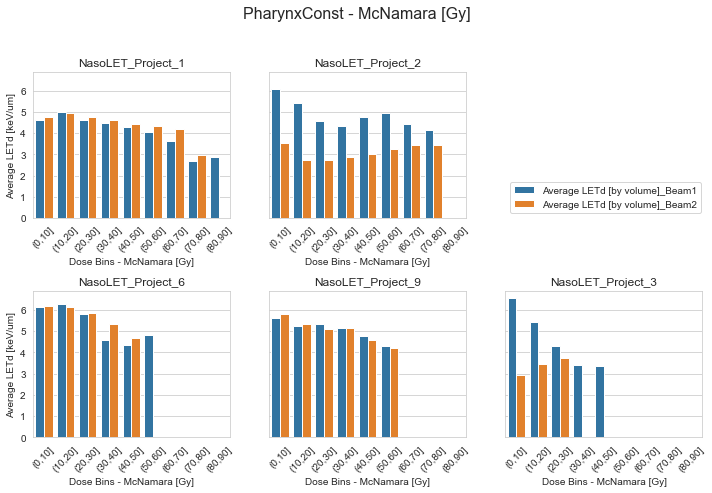

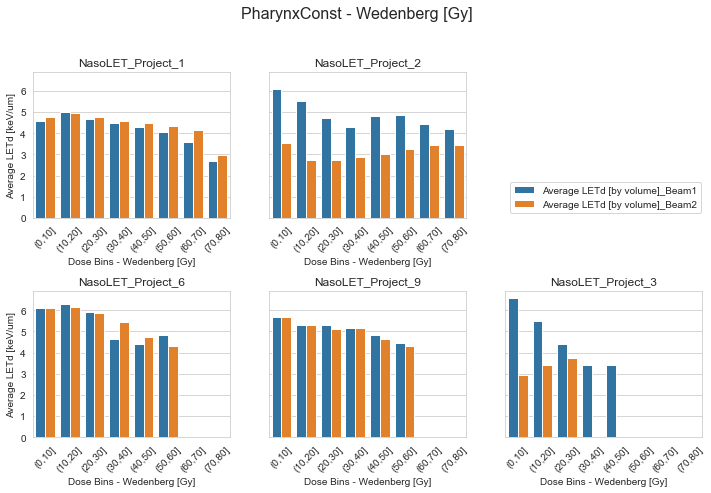

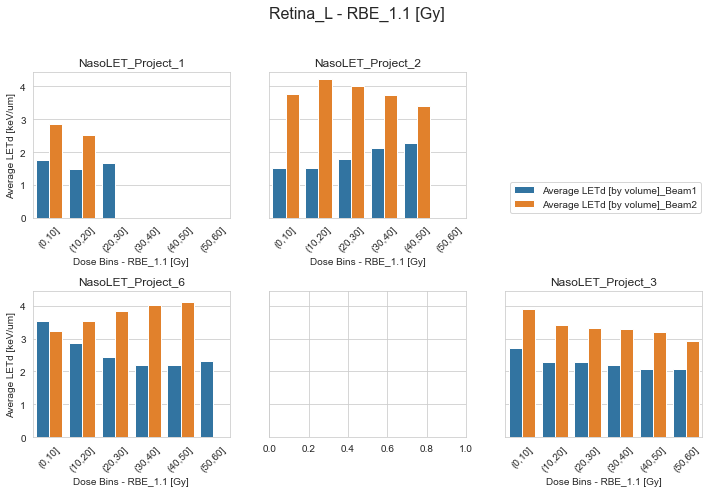

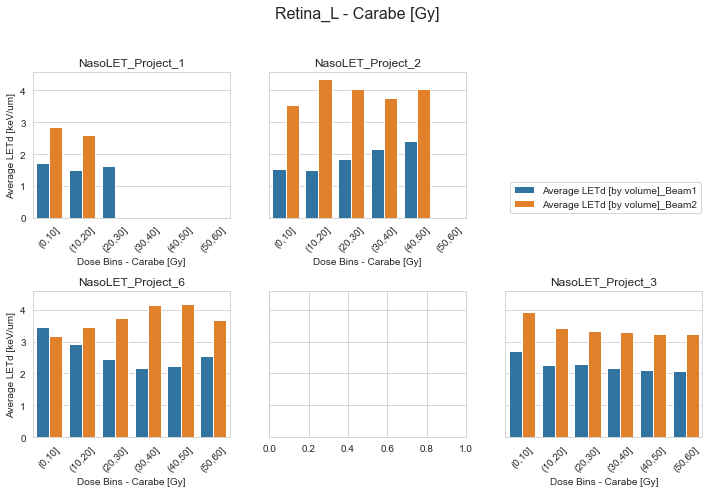

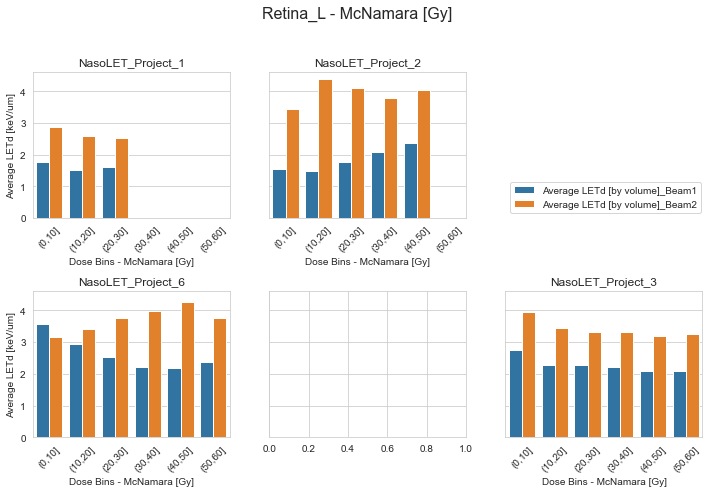

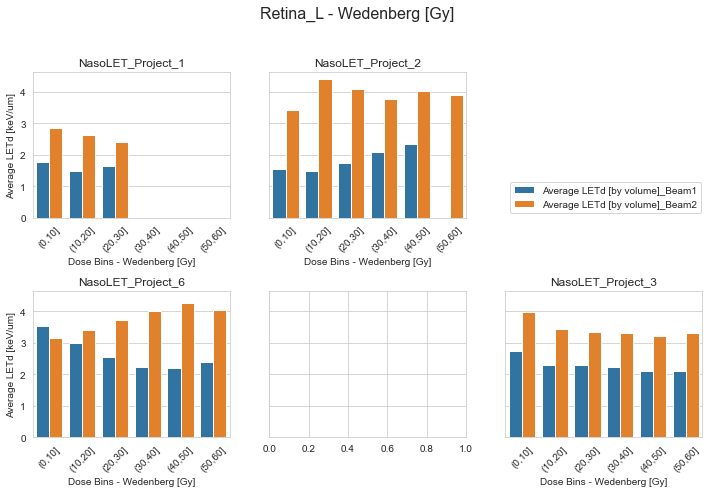

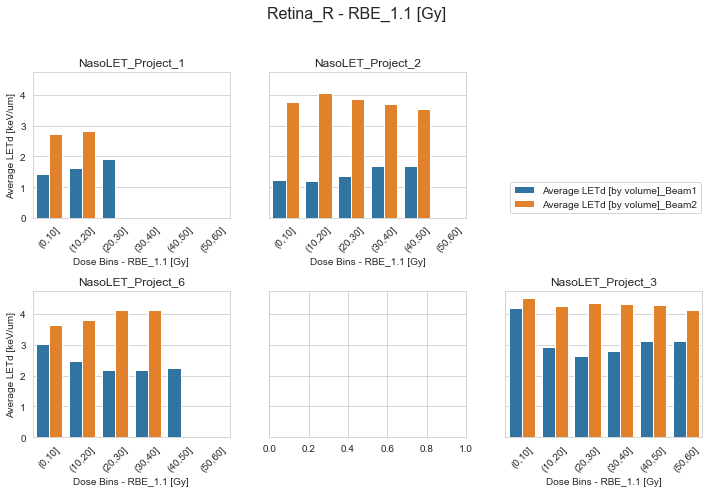

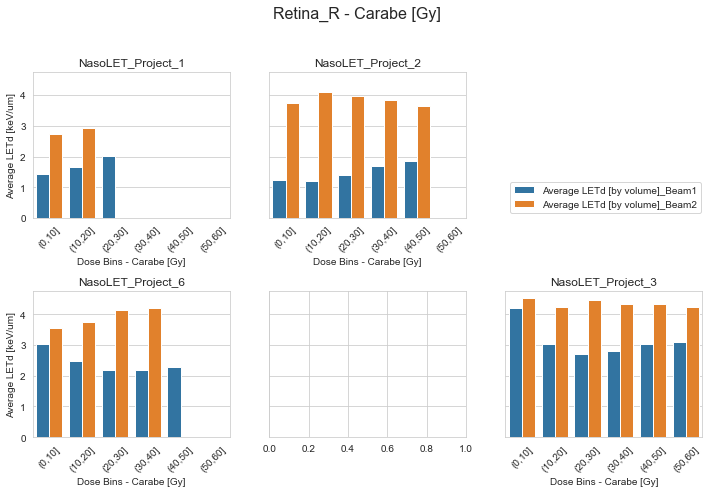

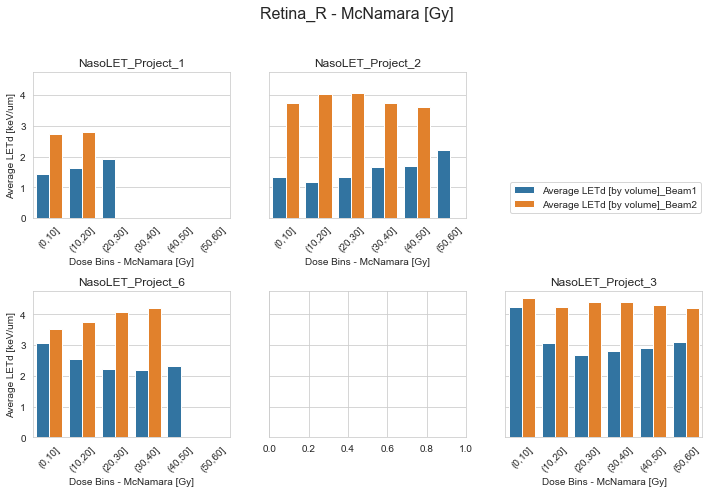

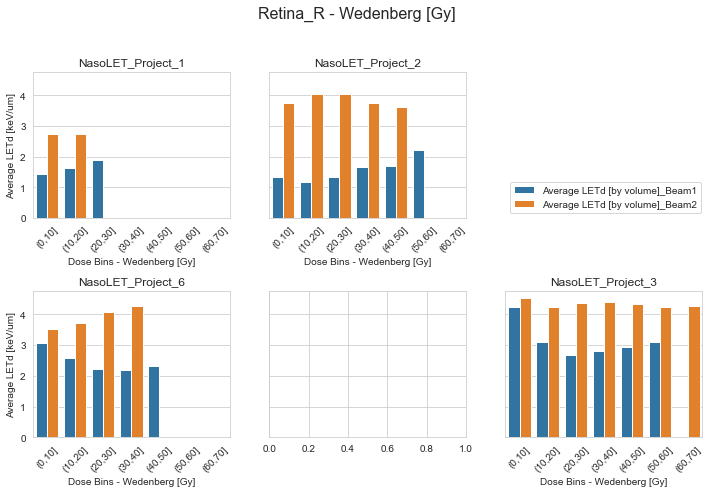

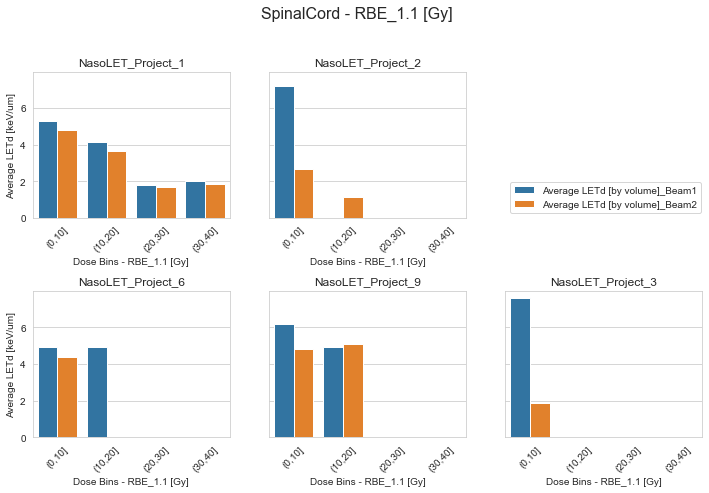

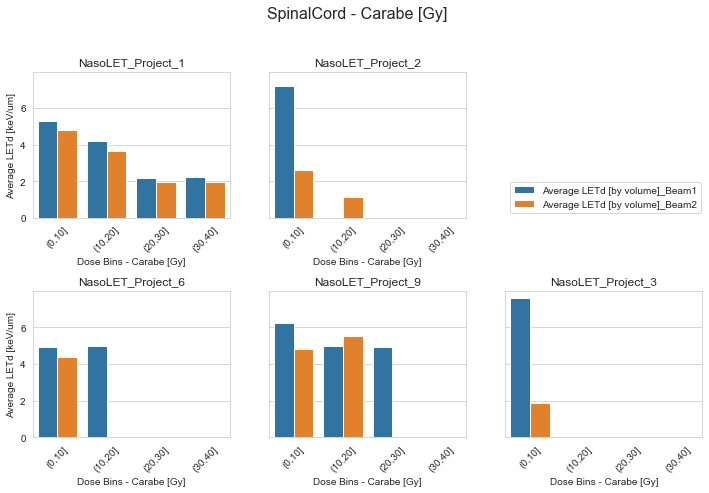

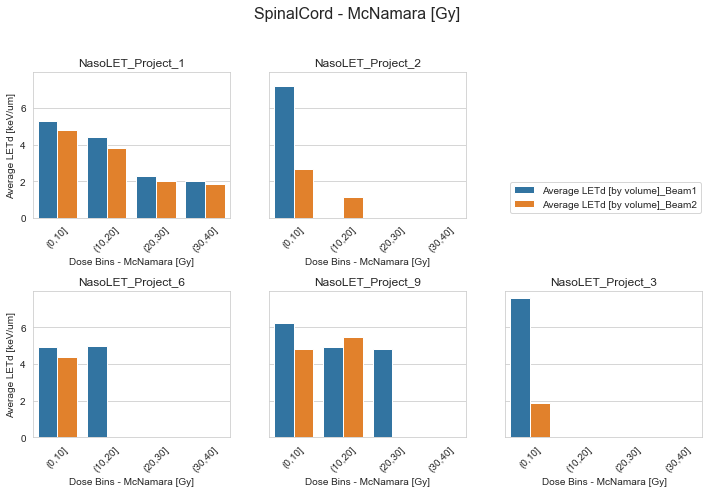

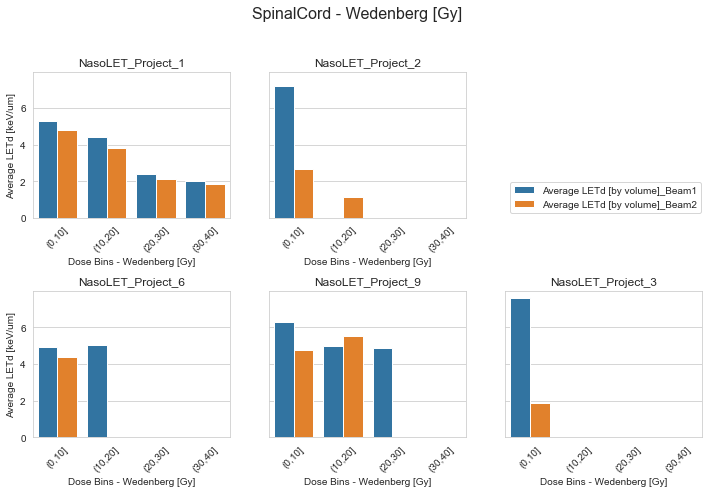

In [164]:
from tqdm import tqdm


for roi,data in df.groupby('ROI'):
    for model in data['Model'].unique():
        if model == 'LETd [keV/um]':
            continue
        # Lets get the max dose so we can make our bins
        max_value = np.ceil(df.loc[(df['Model'] == model) & (df['ROI'] == roi)]['Max'].max())
        bins = np.arange(0,max_value+10,10)
        fig,axs = plt.subplots(2,3,figsize=(12,7), sharey=True)
        fig.suptitle(f'{roi} - {model}', fontsize=16)
        fig.subplots_adjust(top = .85, hspace=.5)
        for idx, patient in enumerate(tqdm(data['Patient'].unique(), desc="Processing patients")):
            
            df_ldvh = get_ldvh(df, patient, roi, model, Bins = bins)
            df_ldvh.loc[:,'Bin'] = df_ldvh['Bin'].apply(lambda x: f"({int(x.left)},{int(x.right)}]")
            #df_ldvh['Bin'] = df_ldvh['Bin'].apply(lambda x:x.mid).astype(float)
            # Get bin_spacing
            #bin_spacing = df_ldvh['Bin'].iloc[:2].diff().iloc[1]
            #bins = np.arange(np.min(df_ldvh['Bin'])-bin_spacing/2, np.max(df_ldvh['Bin'])+bin_spacing/2, bin_spacing)
            #sns.set_style('whitegrid')

            
            
            if idx == 2:
                #ax = fig.add_subplot(2,3,6)
                ax = axs[1,2]
                barplot = sns.barplot(x='Bin', y='value', hue='variable', data=df_ldvh, ax=ax)
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles=handles, labels=labels, bbox_to_anchor=(0, 1.5), loc='lower left')
            else:
                ax = axs[idx//3, idx%3]
                #ax = fig.add_subplot(2,3,idx+1)
                barplot = sns.barplot(x='Bin', y='value', hue='variable', data=df_ldvh, ax=ax, legend=False)
            ax.set_title(f'{patient}')
            ax.set_xlabel(f'Dose Bins - {model}')
            ax.set_ylabel('Average LETd [keV/um]')
            
            '''
            # set xticks to be at bins
            ax[idx//3, idx%3].set_xticks(bins)'''
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)
            '''
            if idx <=1:
                ax.get_xaxis().set_visible(False)
            '''
        # remove ax[0,-1]
        axs[0,-1].axis('off')
        export_fol = r'\\ad\dfs\Shared Data\MCI Proton\Mauricio\Computational physicist\dose_let_stats\figures'
        export_path = os.path.join(export_fol, f'{roi}_{model}.png')
        fig.savefig(export_path, dpi=300)
            
        
    
    


In [153]:
x = df_ldvh.loc[:,'Bin'].iloc[0]

In [159]:
x.left

0.0

In [158]:
x.right

10.0

<AxesSubplot:xlabel='Bin', ylabel='value'>

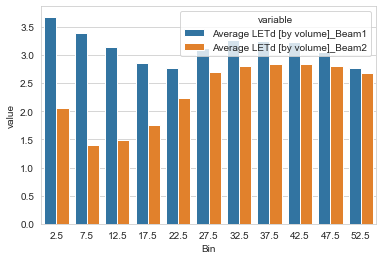

In [104]:
fig,ax = plt.subplots()
sns.barplot(x='Bin', y='value', hue='variable', data=df_ldvh, ax = ax)

<AxesSubplot:xlabel='value', ylabel='Count'>

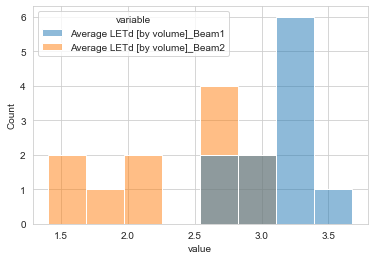

In [100]:
#I want to make a histogram of df_ldvh
fig,ax = plt.subplots()
sns.histplot(data=df_ldvh, x='value', hue='variable',ax = ax)

In [44]:
len(data['Patient'].unique())

5

In [175]:
fig

('NasoLET_Project_1', 'Brain', 'Carabe [Gy]')

In [23]:
fig.savefig(r'\\ad\dfs\Shared Data\MCI Proton\Mauricio\Computational physicist\trial.png',dpi=300)

In [157]:
# Let's only look at patient NasoLET_Project_3
df = df[df['Patient'] == 'NasoLET_Project_3']

In [158]:
# Let's look at the BrainStem data
df = df[df['ROI'] == 'BrainStem']

In [160]:
# Now let's focus only on Beam1_Clinical_norm
df1 = df[df['Plan'] == 'Beam1_Clinical_norm'].copy()
df2 = df[df['Plan'] == 'Beam2_Test_norm'].copy()
# Let's get the dose values for RBE_1.1 and LETd
dose_values1= get_dose_values(df1.loc[(df1['Model'] == 'RBE_1.1 [Gy]')].iloc[0,-1])
letd_values1= get_dose_values(df1.loc[(df1['Model'] == 'LETd [keV/um]')].iloc[0,-1])
dose_values2= get_dose_values(df2.loc[(df2['Model'] == 'RBE_1.1 [Gy]')].iloc[0,-1])
letd_values2= get_dose_values(df2.loc[(df2['Model'] == 'LETd [keV/um]')].iloc[0,-1])

num_bins = 20

bins = np.linspace(0,np.ceil(np.max([letd_values1['letd'].max(),letd_values2['letd'].max()])),num_bins)
letd_values1['Bin'] = pd.cut(letd_values1['letd'], bins)
letd_values2['Bin'] = pd.cut(letd_values2['letd'], bins)

# Merge dose and letd values on index
df_1 = pd.merge(dose_values1, letd_values1, on=['index','weights'], suffixes=('_dose', '_letd'))
df_2 = pd.merge(dose_values2, letd_values2, on=['index','weights'], suffixes=('_dose', '_letd'))

df_1['Dose*Weight'] = df_1['dose']*df_1['weights']
df_2['Dose*Weight'] = df_2['dose']*df_2['weights']

df_ldvh_1 = df_1.groupby('Bin').sum()
df_ldvh_1.reset_index(inplace=True)

df_ldvh_2 = df_2.groupby('Bin').sum()
df_ldvh_2.reset_index(inplace=True)

# merge df_ldvh
df_ldvh = pd.merge(df_ldvh_1, df_ldvh_2, on='Bin', suffixes=('_Beam1', '_Beam2'))

# Only keep Bin, and letd sums
df_ldvh = df_ldvh[['Bin','Dose*Weight_Beam1','Dose*Weight_Beam2']]
# Melt the data
df_ldvh_melt = pd.melt(df_ldvh, id_vars=['Bin'], value_vars=['Dose*Weight_Beam1','Dose*Weight_Beam2'])


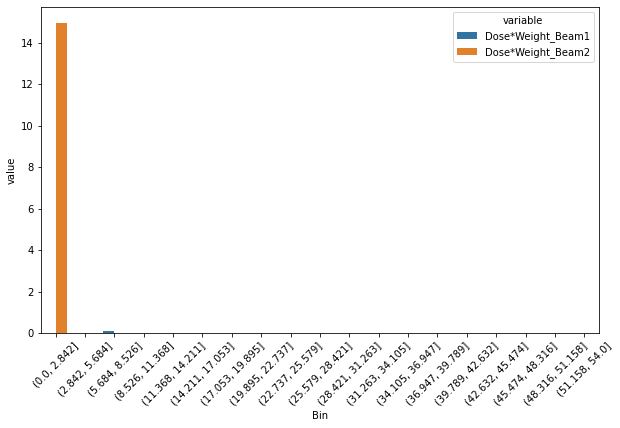

In [161]:
plt.figure(figsize=(10,6))
sns.barplot(x='Bin',y='value',hue='variable',data=df_ldvh_melt)
#rotate xlabels
plt.xticks(rotation=45);

# LETd vs Dose

In [162]:
# Now let's focus only on Beam1_Clinical_norm
df1 = df[df['Plan'] == 'Beam1_Clinical_norm'].copy()
df2 = df[df['Plan'] == 'Beam2_Test_norm'].copy()
# Let's get the dose values for RBE_1.1 and LETd
dose_values1= get_dose_values(df1.loc[(df1['Model'] == 'RBE_1.1 [Gy]')].iloc[0,-1])
letd_values1= get_dose_values(df1.loc[(df1['Model'] == 'LETd [keV/um]')].iloc[0,-1])
dose_values2= get_dose_values(df2.loc[(df2['Model'] == 'RBE_1.1 [Gy]')].iloc[0,-1])
letd_values2= get_dose_values(df2.loc[(df2['Model'] == 'LETd [keV/um]')].iloc[0,-1])

#num_bins = 6

#bins = np.linspace(0,np.ceil(np.max([dose_values1['dose'].max(),dose_values2['dose'].max()])),num_bins)
bins = np.arange(0,np.ceil(np.max([dose_values1['dose'].max(),dose_values2['dose'].max()]))+5,5)
dose_values1['Bin'] = pd.cut(dose_values1['dose'], bins)
dose_values2['Bin'] = pd.cut(dose_values2['dose'], bins)

# Merge dose and letd values on index
df_1 = pd.merge(dose_values1, letd_values1, on=['index','weights'], suffixes=('_dose', '_letd'))
df_2 = pd.merge(dose_values2, letd_values2, on=['index','weights'], suffixes=('_dose', '_letd'))

df_1['LETd*Weight'] = df_1['letd']*df_1['weights']
df_2['LETd*Weight'] = df_2['letd']*df_2['weights']

df_ldvh_1 = df_1.groupby('Bin').sum()
df_ldvh_1.reset_index(inplace=True)
df_ldvh_1['Average LETd [by volume]'] = df_ldvh_1['LETd*Weight']/df_ldvh_1['weights']

df_ldvh_2 = df_2.groupby('Bin').sum()
df_ldvh_2.reset_index(inplace=True)
df_ldvh_2['Average LETd [by volume]'] = df_ldvh_2['LETd*Weight']/df_ldvh_2['weights']

# merge df_ldvh
df_ldvh = pd.merge(df_ldvh_1, df_ldvh_2, on='Bin', suffixes=('_Beam1', '_Beam2'))

# Only keep Bin, and letd sums
df_ldvh = df_ldvh[['Bin','Average LETd [by volume]_Beam1','Average LETd [by volume]_Beam2']]
# Melt the data
df_ldvh_melt = pd.melt(df_ldvh, id_vars=['Bin'], value_vars=['Average LETd [by volume]_Beam1','Average LETd [by volume]_Beam2'])


Text(0.5, 1.0, 'Average LETd by volume vs Dose Bins')

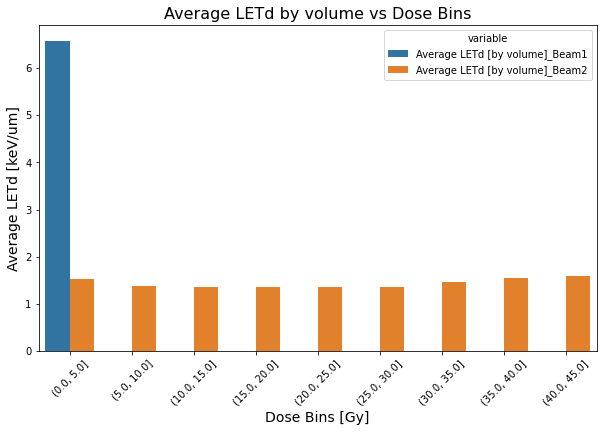

In [163]:
plt.figure(figsize=(10,6))
sns.barplot(x='Bin',y='value',hue='variable',data=df_ldvh_melt)
#rotate xlabels
plt.xticks(rotation=45);
plt.xlabel('Dose Bins [Gy]', fontsize=14)
plt.ylabel('Average LETd [keV/um]', fontsize=14)
plt.title(f'Average LETd by volume vs Dose Bins', fontsize=16)